In [ ]:
import cvxpy as cp
import random
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import newton
from scipy import optimize

### 1) Pick a stock of your choice which is being traded in the derivative market.

### 2)Look at the stock’s and option’s history on YAHOO Finance.

In [ ]:
end_date = '2024-04-19'
start_date = '2023-04-19'
stock_data = yf.download("AAPL", start=start_date, end=end_date)
print(stock_data)

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-19  165.800003  168.160004  165.539993  167.630005  166.740005   
2023-04-20  166.089996  167.869995  165.559998  166.649994  165.765182   
2023-04-21  165.050003  166.449997  164.490005  165.020004  164.143860   
2023-04-24  165.000000  165.600006  163.889999  165.330002  164.452225   
2023-04-25  165.190002  166.309998  163.729996  163.770004  162.900497   
...                ...         ...         ...         ...         ...   
2024-04-12  174.259995  178.360001  174.210007  176.550003  176.550003   
2024-04-15  175.360001  176.630005  172.500000  172.690002  172.690002   
2024-04-16  171.750000  173.759995  168.270004  169.380005  169.380005   
2024-04-17  169.610001  170.649994  168.000000  168.000000  168.000000   
2024-04-18  168.029999  168.639999  166.550003  167.039993  167.039993   

               Volume  
Date         

In [ ]:
# Retrieve option chain for AAPL
option_chain = yf.Ticker("AAPL").option_chain('2024-04-19')

# Display option chain
print(option_chain.calls)
print(option_chain.puts)

         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0   AAPL240419C00005000 2024-04-16 16:14:01+00:00     5.0     164.30  159.40   
1   AAPL240419C00010000 2024-04-18 19:48:55+00:00    10.0     157.15  153.75   
2   AAPL240419C00015000 2024-04-04 14:55:59+00:00    15.0     155.95  148.80   
3   AAPL240419C00030000 2024-03-27 15:14:12+00:00    30.0     142.65  133.45   
4   AAPL240419C00035000 2024-04-12 14:02:42+00:00    35.0     142.43  128.70   
..                  ...                       ...     ...        ...     ...   
69  AAPL240419C00280000 2024-04-18 16:07:12+00:00   280.0       0.01    0.00   
70  AAPL240419C00285000 2024-03-13 13:38:31+00:00   285.0       0.01    0.00   
71  AAPL240419C00290000 2024-02-22 19:04:11+00:00   290.0       0.01    0.00   
72  AAPL240419C00295000 2024-04-11 18:10:46+00:00   295.0       0.01    0.00   
73  AAPL240419C00300000 2024-04-18 19:55:14+00:00   300.0       0.01    0.00   

       ask  change  percentChange  volu

Visualising the data

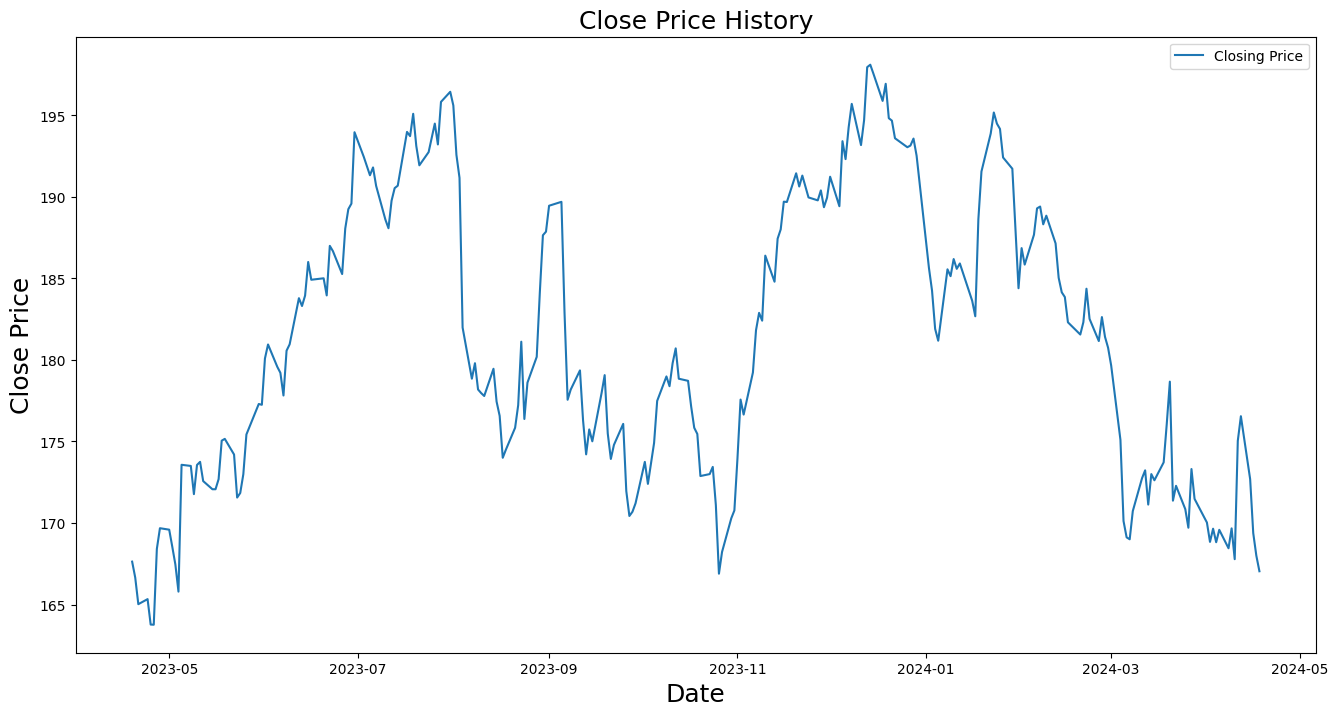

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Close Price History",fontsize=18)
plt.plot( stock_data['Close'],label='Closing Price')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.legend()
plt.show()

In [ ]:
simple_returns=stock_data['Close'].pct_change()

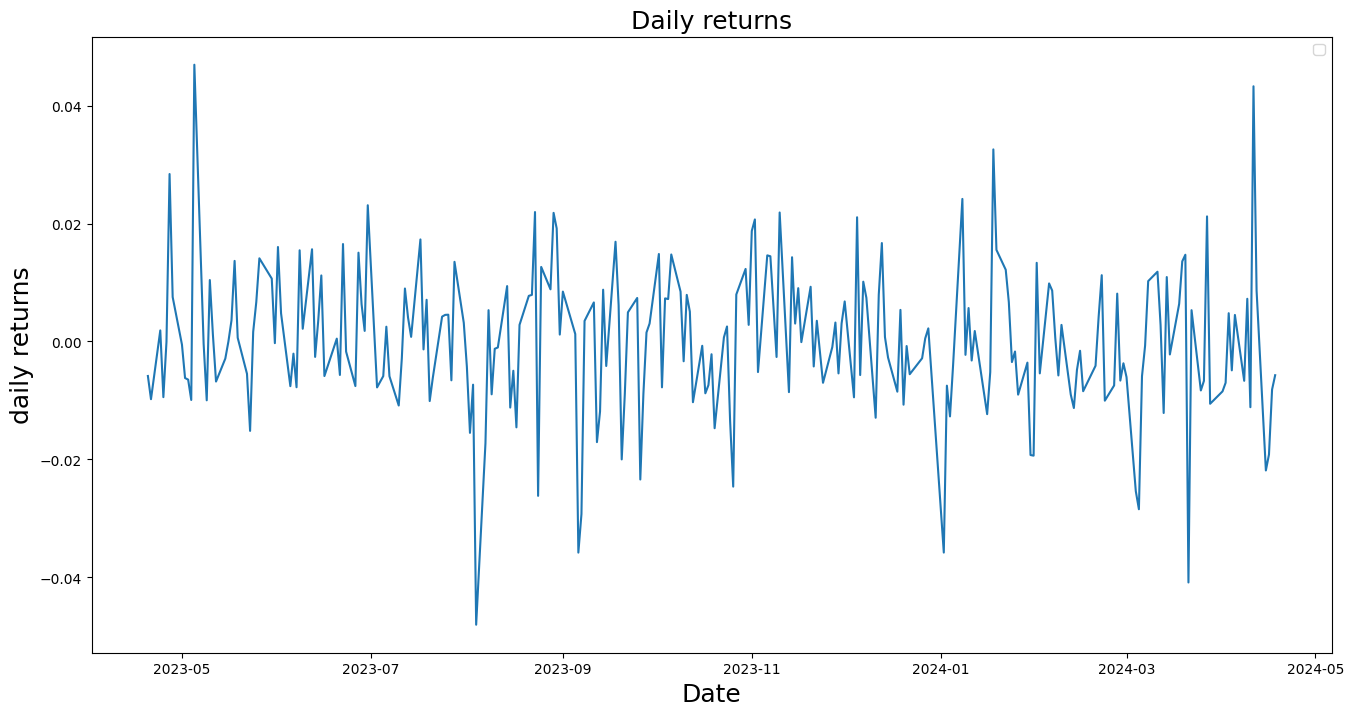

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Daily returns",fontsize=18)
plt.plot( simple_returns)
plt.xlabel('Date',fontsize=18)
plt.ylabel('daily returns',fontsize=18)
plt.legend()
plt.show()

In [ ]:
mu = simple_returns.mean()

In [ ]:
print(mu)

6.226690534832913e-05


### 3) Use past one-year data to estimate the annual volatility.

In [ ]:
# Calculate the daily returns
stock_data['daily_return'] = stock_data['Close'].pct_change()

# Calculate the annual volatility
volatility = np.sqrt(252) * stock_data['daily_return'].std()

print("Simple Returns:")
print(stock_data['daily_return'])

print("\nVolatility:")
print(volatility)

Simple Returns:
Date
2023-04-19         NaN
2023-04-20   -0.005846
2023-04-21   -0.009781
2023-04-24    0.001879
2023-04-25   -0.009436
                ...   
2024-04-12    0.008627
2024-04-15   -0.021863
2024-04-16   -0.019167
2024-04-17   -0.008147
2024-04-18   -0.005714
Name: daily_return, Length: 252, dtype: float64

Volatility:
0.19639071670300964


 ### 4) Use 10 years’ US treasury rate as the rate of interest.

 10 Year Treasury Rate is at 4.64%.

In [ ]:
rf=0.0464

### 5) Now fix different strike prices and time of maturity to evaluate the call/ put option price by using Binomial model

In [ ]:

#binomial model
def binomial_model(S, K, T, r, sigma, N, option_type):

    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_price = np.zeros((N+1, N+1))
    option_value = np.zeros((N+1, N+1))

    for i in range(N+1):
        for j in range(i+1):
            stock_price[j, i] = S * (u ** (i-j)) * (d ** j)

    if option_type == "Put":
        option_value[:, N] = np.maximum(0, K - stock_price[:, N])
    elif option_type == "Call":
        option_value[:, N] = np.maximum(0,stock_price[:, N]-K)

    for i in range(N-1, -1, -1):
        for j in range(i+1):
            option_value[j, i] = np.exp(-r * dt) * (p * option_value[j, i+1] + (1-p) * option_value[j+1, i+1])
    stock_price = stock_price[0, 0]
    option_price = option_value[0, 0]

    return option_price, stock_price

In [ ]:
S0 = stock_data['Close'][-1]  # Current stock price
K_values = [S0 * 0.9, S0 * 1.0, S0 * 1.1]  # Strike prices
T_values = [30/365, 60/365, 90/365]  # Time to maturity in years
N=5
for K in K_values:
    for T in T_values:
        option_price_call,stock_price_call = binomial_model(S0, K, T, rf, volatility, N, option_type='Call')
        option_price_put,stock_price_put = binomial_model(S0, K, T, rf,volatility, N, option_type='Put')
        print(f"Strike Price: {K:.2f}, Time to Maturity: {T:.2f}")
        print(f"Call Option Price: {option_price_call:.4f}")
        print(f"Put Option Price: {option_price_put:.4f}")

Strike Price: 150.34, Time to Maturity: 0.08
Call Option Price: 17.3633
Put Option Price: 0.0870
Strike Price: 150.34, Time to Maturity: 0.16
Call Option Price: 18.1659
Put Option Price: 0.3196
Strike Price: 150.34, Time to Maturity: 0.25
Call Option Price: 19.3692
Put Option Price: 0.9550
Strike Price: 167.04, Time to Maturity: 0.08
Call Option Price: 4.2601
Put Option Price: 3.6243
Strike Price: 167.04, Time to Maturity: 0.16
Call Option Price: 6.2085
Put Option Price: 4.9392
Strike Price: 167.04, Time to Maturity: 0.25
Call Option Price: 7.7751
Put Option Price: 5.8748
Strike Price: 183.74, Time to Maturity: 0.08
Call Option Price: 0.1940
Put Option Price: 16.1986
Strike Price: 183.74, Time to Maturity: 0.16
Call Option Price: 0.9116
Put Option Price: 16.2194
Strike Price: 183.74, Time to Maturity: 0.25
Call Option Price: 1.9854
Put Option Price: 16.5991


### 6) Evaluate the option price by using Black Scholes Formula

In [ ]:
#black scholes model
def black_scholes(S, K, T, r, sigma, option_type):

    d1 = (np.log(S/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "Call":
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "Put":
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return option_price

In [ ]:
black_scholes_call_values=[]
black_scholes_put_values=[]
for K in K_values:
    black_scholes_calls=[]
    black_scholes_puts=[]
    for T in T_values:
        option_price_call = black_scholes(S0, K, T, rf, volatility, option_type='Call')
        option_price_put = black_scholes(S0, K, T, rf,volatility, option_type='Put')
        black_scholes_calls.append(option_price_call)
        black_scholes_puts.append(option_price_put)
        print(f"Strike Price: {K:.2f}, Time to Maturity: {T:.2f}")
        print(f"Call Option Price: {option_price_call:.4f}")
        print(f"Put Option Price: {option_price_put:.4f}")
    black_scholes_call_values.append(black_scholes_calls)
    black_scholes_put_values.append(black_scholes_puts)

Strike Price: 150.34, Time to Maturity: 0.08
Call Option Price: 17.3651
Put Option Price: 0.0889
Strike Price: 150.34, Time to Maturity: 0.16
Call Option Price: 18.2880
Put Option Price: 0.4417
Strike Price: 150.34, Time to Maturity: 0.25
Call Option Price: 19.2796
Put Option Price: 0.8654
Strike Price: 167.04, Time to Maturity: 0.08
Call Option Price: 4.0709
Put Option Price: 3.4351
Strike Price: 167.04, Time to Maturity: 0.16
Call Option Price: 5.9434
Put Option Price: 4.6742
Strike Price: 167.04, Time to Maturity: 0.25
Call Option Price: 7.4537
Put Option Price: 5.5534
Strike Price: 183.74, Time to Maturity: 0.08
Call Option Price: 0.2156
Put Option Price: 16.2202
Strike Price: 183.74, Time to Maturity: 0.16
Call Option Price: 0.9508
Put Option Price: 16.2587
Strike Price: 183.74, Time to Maturity: 0.25
Call Option Price: 1.8334
Put Option Price: 16.4472


### 7) Increase the number of steps in Binomial model to verify that the price converges to 6.

### 8) Draw the graph to show 7.

In [ ]:
# Function to draw convergence graph
def draw_convergence_graph(S, K, T, r, sigma, n_range,idx1,idx2):
    option_prices_call = []
    option_prices_put=[]
    for n in range(1,n_range):
        option_price_call,stockprice_call = binomial_model(S, K, T, r, sigma, n,"Call")
        option_prices_call.append(option_price_call)
        option_price_put,stockprice_put = binomial_model(S, K, T, r, sigma, n,"Put")
        option_prices_put.append(option_price_put)
    plt.plot([i for i in range(1,n_range)], option_prices_call, marker='o')
    plt.plot([i for i in range(1,n_range)],[black_scholes_call_values[idx1][idx2] for i in range(1,n_range)])
    plt.xlabel('Number of Steps')
    plt.ylabel('Option Price')
    plt.title('Convergence of Call Option Price for Strike price {} \nand time of maturity {}'.format(K,T))
    plt.grid(True)
    plt.show()

    plt.plot([i for i in range(1,n_range)], option_prices_put, marker='o')
    plt.plot([i for i in range(1,n_range)],[black_scholes_put_values[idx1][idx2] for i in range(1,n_range)])
    plt.xlabel('Number of Steps')
    plt.ylabel('Option Price')
    plt.title('Convergence of Put Option Price for Strike price {} \nand time of maturity {}'.format(K,T))
    plt.grid(True)
    plt.show()


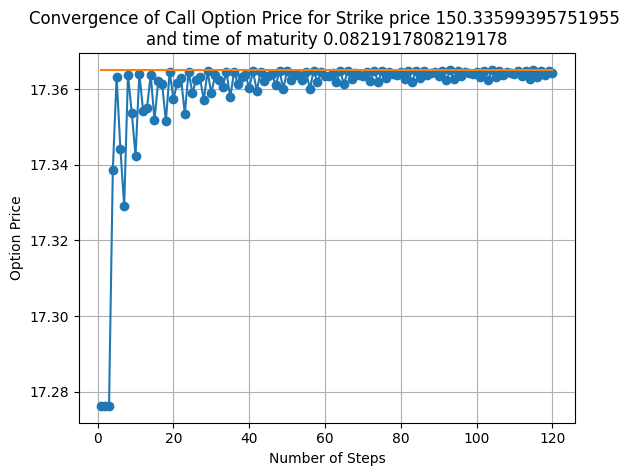

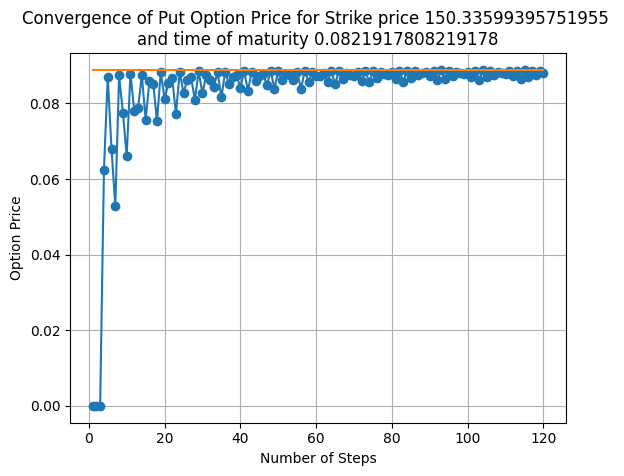

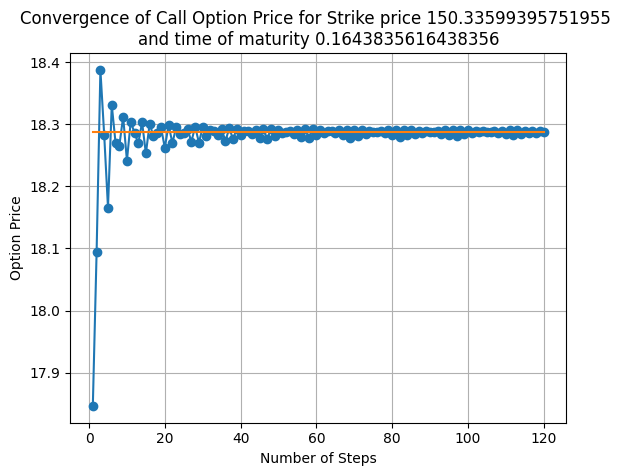

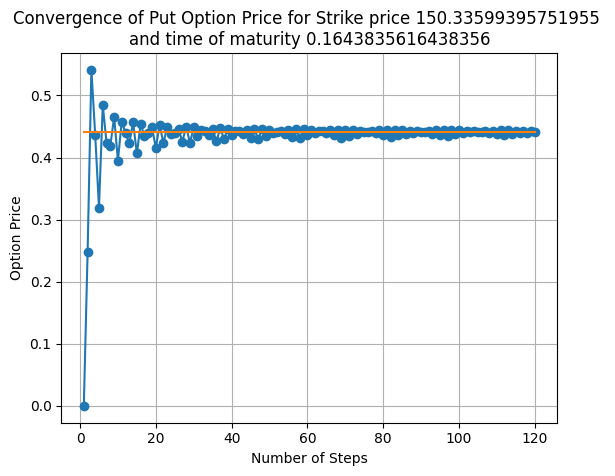

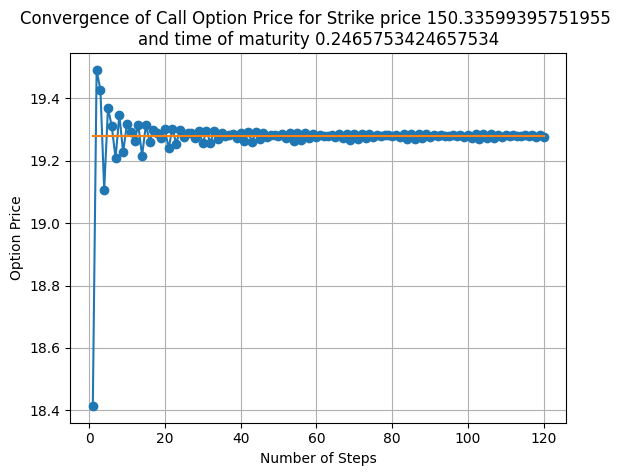

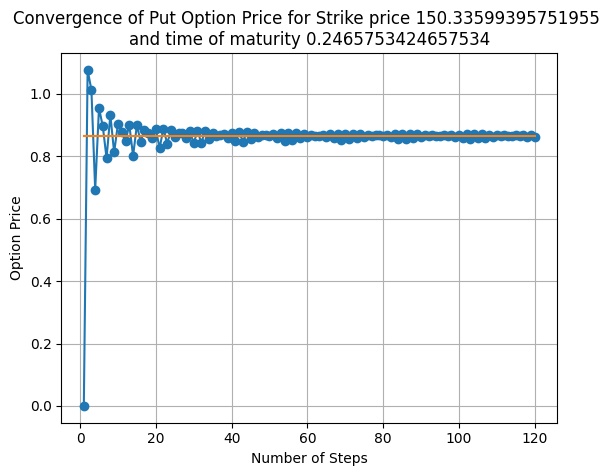

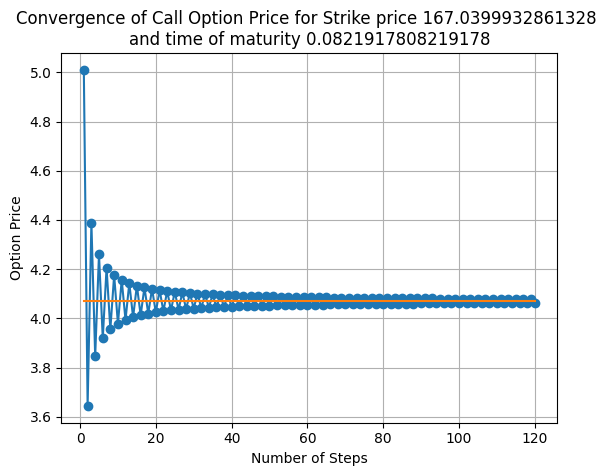

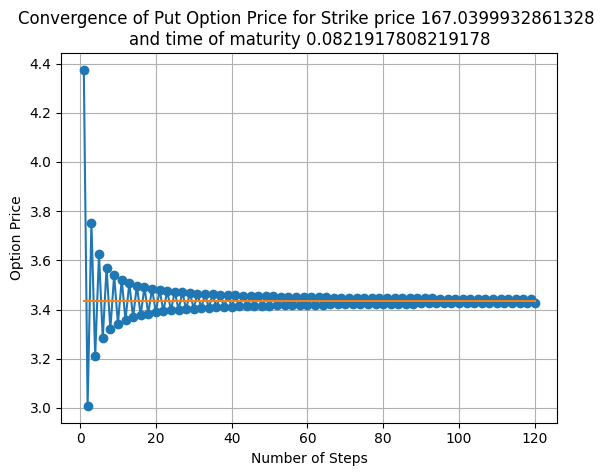

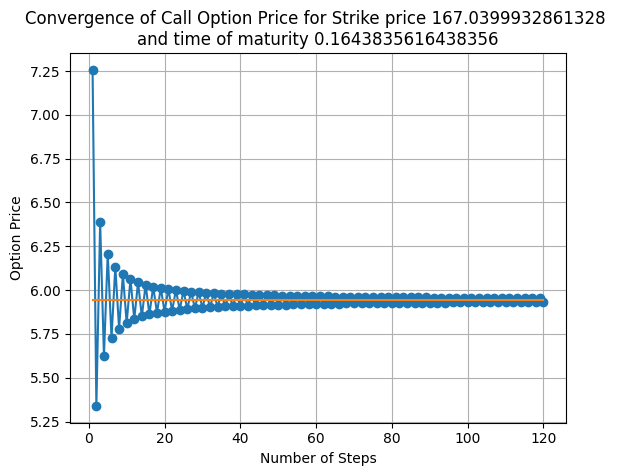

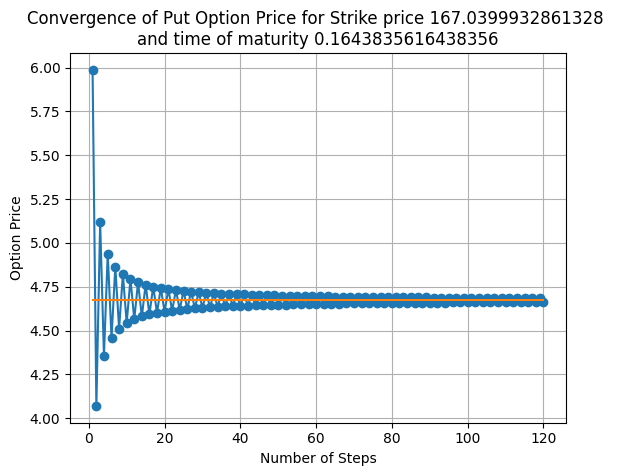

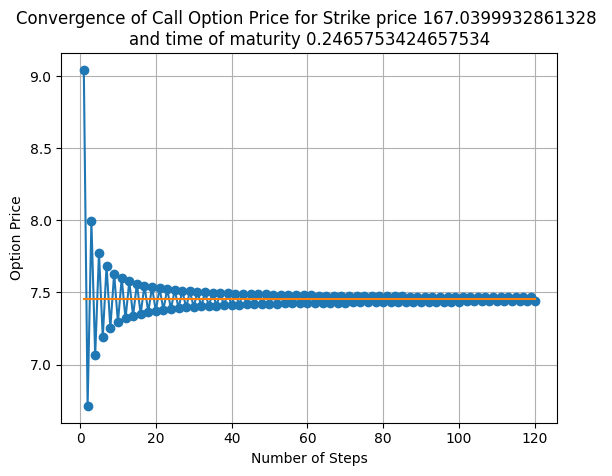

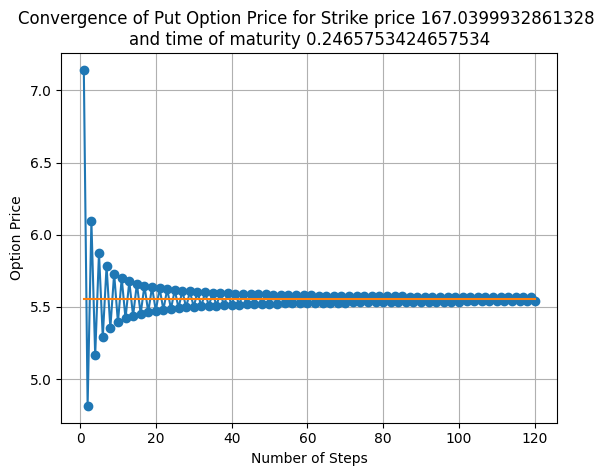

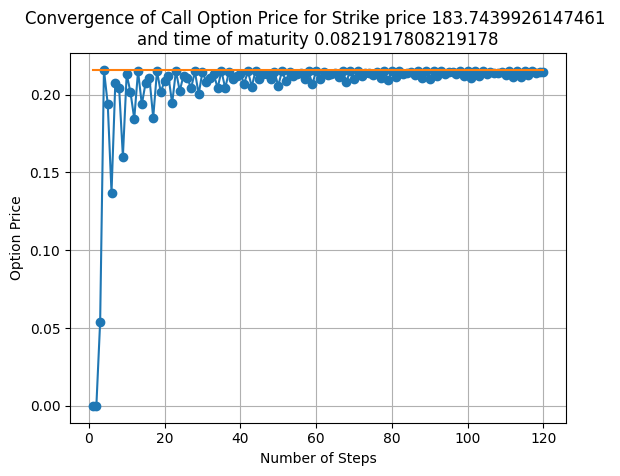

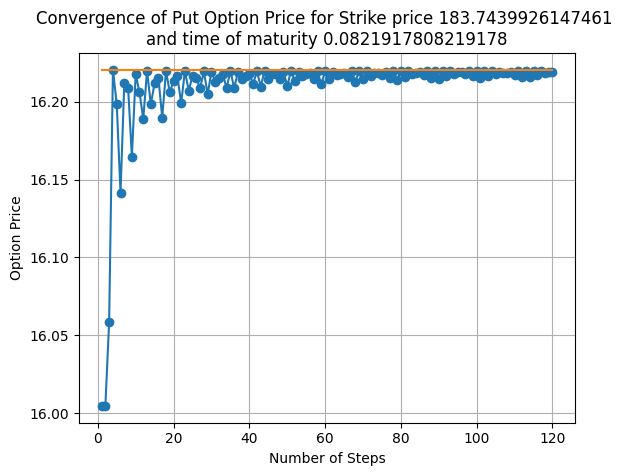

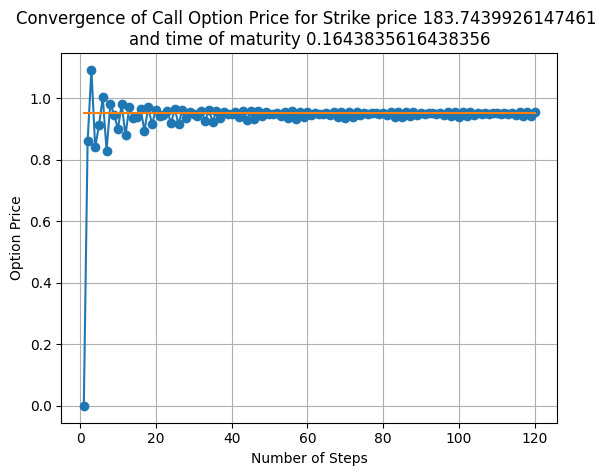

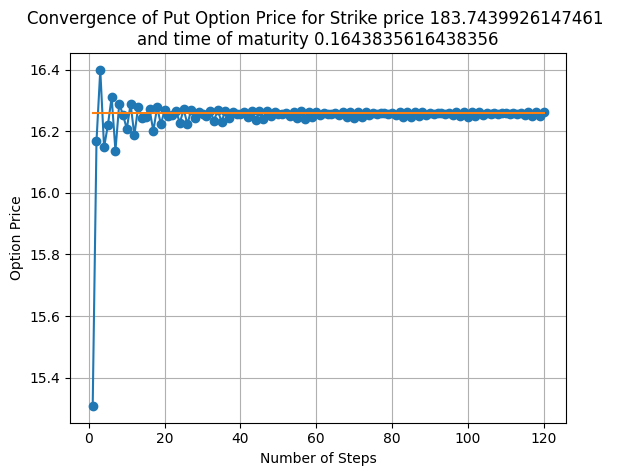

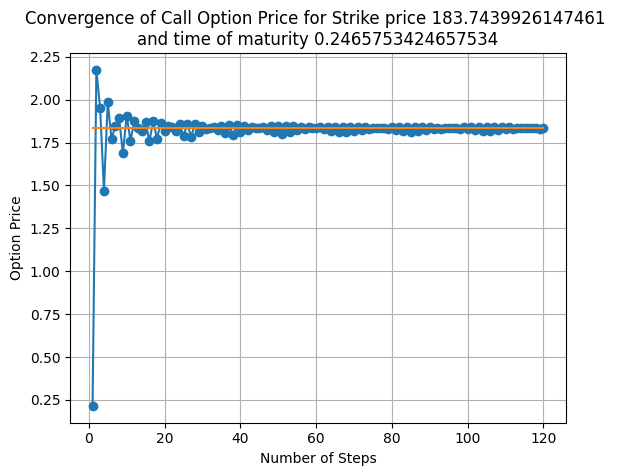

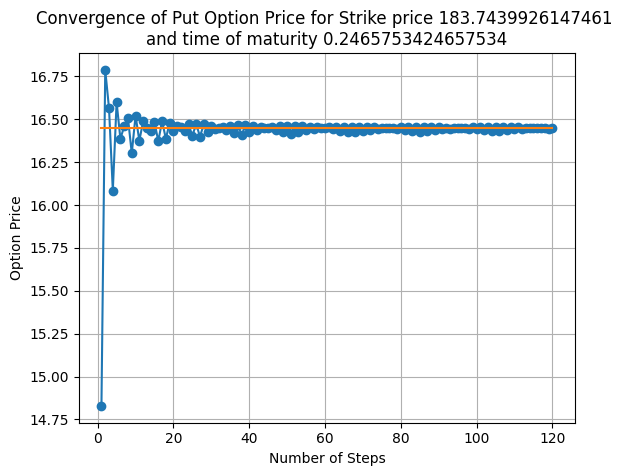

In [ ]:
for i in range(len(K_values)):
    for j in range(len(T_values)):
      draw_convergence_graph(S0, K_values[i], T_values[j], rf,volatility,121,i,j)

### 9) Compare with the actual market data


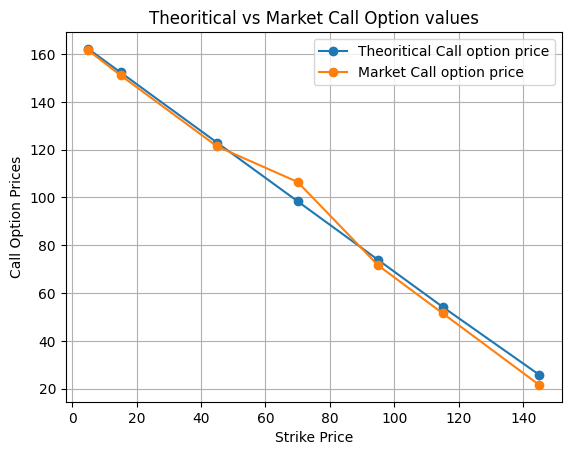

In [ ]:
S0 = stock_data['Close'][-1]  # Current stock price
K_values = [5,15,45,70,95,115,145]  # Strike prices
T_values = [150/365]  # Time to maturity in years
N=5
calculated_call_values=[]
for K in K_values:
    for T in T_values:
        option_price_call,stock_price_call = binomial_model(S0, K, T, rf, volatility, N, option_type='Call')
        calculated_call_values.append(option_price_call)

market_call_values=[161.5,151.1,121.35,106.45,71.55,51.55,21.55]
plt.plot(K_values,calculated_call_values , marker='o',label='Theoritical Call option price')
plt.plot(K_values,market_call_values, marker='o',label='Market Call option price')
plt.xlabel('Strike Price')
plt.ylabel('Call Option Prices')
plt.title("Theoritical vs Market Call Option values")
plt.legend()
plt.grid(True)
plt.show()



### 10) Create a delta neutral portfolio

Denote the European call option price in the Black–Scholes model by CE(S).
The delta of the option is given by

d/dS(CE(S))  = N(d1)

where d1 = (np.log(S/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))

In [ ]:
sigma=volatility
T=150/365
K=70
d1 = (np.log(S0/K) + (rf + sigma**2/2) * T) / (sigma * np.sqrt(T))
delta = norm.cdf(d1)
CE=black_scholes(S0,K,T,rf,sigma,"Call")
# V(S) = xS + y − CE(S)

x=delta
print(CE)
print(x)
print(x*S0)
y=CE-x*S0
print(y)
print(x*S0+y-CE)


98.36214205264946
0.9999999999994706
167.0399932860444
-68.67785123339493
0.0


### 11) Use numerical methods to get implied volatility.

In [ ]:
option_price=106.5
N_prime = norm.pdf
def helper(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    return S * N_prime(d1) * np.sqrt(T)

def implied_volatility_call(C, S, K, T, r, tol=0.0001,max_iterations=100):
    sigma = 1
    for i in range(max_iterations):
        diff = black_scholes(S, K, T, r, sigma,"Call") - C
        if abs(diff) < tol:
            print(f'found on {i}th iteration')
            print(f'difference is equal to {diff}')
            break
        else:
          sigma = sigma - diff / helper(S, K, T, r, sigma)

    return sigma


In [ ]:
imp_vol = implied_volatility_call(option_price, S0, K, T, rf)
print('Implied volatility using Newton Rapshon is: ',imp_vol)

found on 3th iteration
difference is equal to 4.74442727238511e-05
Implied volatility using Newton Rapshon is:  1.4315038253794679
